In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    # Store the actual data value
    self.data = data
    # Will store the gradient during backpropagation
    self.grad = 0.0
    # Function that will compute gradients during backpropagation
    self._backward = lambda: None
    # References to input values that created this value
    self._prev = set(_children)
    # Operation that created this value (for debugging)
    self._op = _op
    # Optional label for visualization
    self.label = label

  def __repr__(self):
    # String representation of the Value
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    # Addition operation, creates a new Value
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      # Gradient flows unchanged through addition
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    # Multiplication operation, creates a new Value
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      # Chain rule for multiplication: gradient * the other input
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    # Hyperbolic tangent activation function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      # Derivative of tanh is (1 - tanh²)
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    # Performs backpropagation through the computational graph
    
    # First, topologically sort the graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    # Seed the gradient of the output node with 1.0
    self.grad = 1.0
    # Process nodes in reverse topological order
    for node in reversed(topo):
      node._backward()

Value(data=-8.0)

In [ ]:
# Creating input values
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Building the computation graph
e = a*b; e.label = 'e'  # e = -6.0
d = e + c; d.label = 'd'  # d = 4.0
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'  # L = -8.0

# Display the final result
L

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

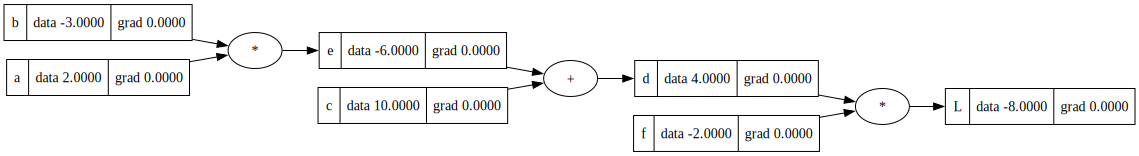

In [6]:
draw_dot(L)

Note: you may need to restart the kernel to use updated packages.
